In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cpu


# 1. Problem Setting
---

## Step1. Constants 정의
---
### General
- N_TRIAL: Trial 횟수
- N_ARMS: Arms들의 갯수
- N_FEATURES: 각 arm의 feature 수

In [3]:
N_TRIALS = 10000
N_ARMS = 10
N_FEATURES = 5

## Step2. Design Matrix $X$ (= Arms) 생성
---
### General
- Arm 번호 리스트 생성: n_arms에 따른 각 [0, 1, ..., n_arms] 생성
- Design Matrix X(=Arm List) 생성: n_arms만큼의 x를 생성

### For experiment
- 모든 trial에서 arm set 모두 동일하게 고정

In [4]:
def make_design_matrix(n_trials, n_arms, n_features):
    """
    Args:
        n_trials : # of trials
        n_arms : # of arms
        n_features : # of features

    Returns:
        X: (n_trials, n_arms, n_features)
    """
    # available_arms: (n_arms,)
    available_arms = np.arange(n_arms) 

    # fixed_arms_list: (n_arms, n_features)
    fixed_arms_list = [np.random.uniform(low=0, high=1, size=n_features) for _ in available_arms] # 
    
    # X: (n_trials, n_arms, n_features)
    X = np.array([fixed_arms_list for _ in np.arange(n_trials)])
    
    # norm으로 나누어 정리
    for trial in np.arange(n_trials):
        for arm in available_arms:
            X[trial, arm, :] /= np.linalg.norm(X[trial, arm, :])
            
    return X

In [5]:
X_example = make_design_matrix(N_TRIALS, N_ARMS, N_FEATURES)
print(f'X shape: {X_example.shape}')
trial_num = 0
print(f'X_trial_{trial_num}:\n{X_example[trial_num,:,:]}')
# print(f'X trial 1:\n{X[1,:,:]}')

X shape: (10000, 10, 5)
X_trial_0:
[[0.67334029 0.66915886 0.03704488 0.31177294 0.01626611]
 [0.344443   0.02934798 0.85056712 0.36829765 0.14625365]
 [0.37295736 0.54274553 0.16562754 0.73315039 0.03725765]
 [0.19483872 0.07859963 0.62262473 0.45410861 0.60165088]
 [0.36050858 0.49615785 0.33957466 0.62820695 0.33749969]
 [0.6202208  0.59546852 0.33420524 0.10377497 0.37186154]
 [0.25397503 0.77303513 0.35201068 0.11409572 0.44831241]
 [0.24015139 0.51875399 0.58539363 0.14407814 0.55657649]
 [0.32209043 0.08221919 0.63416142 0.01539586 0.69792552]
 [0.38143333 0.57751744 0.05907232 0.61704976 0.36978681]]


## Step3. True Theta $\theta^*$ 생성
---
### General
-  각 arm별 true theta 벡터를 생성
### For experiment
- 모든 arm의 theta는 동일하게 고정

In [6]:
def make_true_theta(n_trials, n_arms, n_features, best_arms=0, bias=1):
    """
    Args:
        n_trials : # of trials
        n_arms : # of arms
        n_features : # of features
        best_arms : best_arm_idx
        bias : bias. Defaults to 1.

    Returns:
        true_theta: (n_trials, n_arms, n_features)
    """
    # true_theta_fixed: (n_features, )
    true_theta_fixed = np.random.rand(n_features)
    
    # true_theta: (n_trials, n_arms, n_features)
    true_theta = np.array([[true_theta_fixed for _ in np.arange(n_arms)] for _ in np.arange(n_trials)])

    # X = np.array([fixed_arms_list for _ in np.arange(n_trials)])
    for trial in np.arange(n_trials):
        for arm in np.arange(n_arms):
            true_theta[trial, arm, :] /= np.linalg.norm(true_theta[trial, arm, :])
    return true_theta

In [7]:
true_theta_example = make_true_theta(N_TRIALS, N_ARMS, N_FEATURES)
print(f'True_theta: {true_theta_example.shape}')
trial_num = 0
print(f'True_theta_trial_{trial_num}:\n{true_theta_example[trial_num,:,:]}')

True_theta: (10000, 10, 5)
True_theta_trial_0:
[[0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]
 [0.45181991 0.50320794 0.59695875 0.00845145 0.43151982]]


## Step4. True Model $y$ 생성
---
### General
- Linear Model : $$ y = x^\top \theta^* + \epsilon $$

In [8]:
def generate_true_y(X, true_theta):
    """
    Args:
        X: Design Matrix X, (n_trials, n_arms, n_features)
        true_theta: (n_trials, n_arms, n_features)

    Returns:
        true_y: (n_trials, n_arms)
    """
    n_trials, n_arms, _ = X.shape
    true_y = np.empty(shape=(n_trials, n_arms))
    epsilon = 0

    for trial in np.arange(N_TRIALS):
        for arm in np.arange(N_ARMS):
            true_y[trial, arm] = X[trial,arm,:].T @ true_theta[trial,arm,:] + epsilon

    return true_y

In [9]:
true_y_example = generate_true_y(X_example, true_theta_example)
print(f'true_y: {true_y_example.shape}')
print(f'true_y_trial_0:\n{true_y_example[0]}')
print(f'true_y_trial_1:\n{true_y_example[1]}')

true_y: (10000, 10)
true_y_trial_0:
[0.67272295 0.74437183 0.56276983 0.76272741 0.76621465 0.94072202
 0.90830421 0.96039362 0.86676724 0.66299957]
true_y_trial_1:
[0.67272295 0.74437183 0.56276983 0.76272741 0.76621465 0.94072202
 0.90830421 0.96039362 0.86676724 0.66299957]


## Utils
---

## Generate_Reward 

In [10]:
def generate_reward(chosen_arm_x, chosen_true_theta, scale_noise=0):
    signal = chosen_arm_x.T @ chosen_true_theta
    noise = np.random.normal(scale=scale_noise)
    payoff_reward = signal + noise
    return payoff_reward

# 

# 2. Algorithm
---
##  LinUCB_disjoint

In [11]:
def linUCB_disjoint(alpha, X, true_theta, true_y):
    print("LinUCB disjoint with exploration parameter alpha: ", alpha)
    n_trials, n_arms, n_features = X.shape
    
    # 1. INITIAL OBJECT
    # 1.1. Output object
    arm_choice = np.empty(n_trials)
    r_payoff = np.empty(n_trials)
    theta_hat = np.empty(shape=(n_trials, n_arms, n_features))
    p = np.empty(shape=(n_trials, n_arms))
    regrets = np.empty(n_trials)
    
    # 1.2. Intermediate object
    A = np.array([np.diag(np.ones(shape=n_features)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_features) for _ in np.arange(n_arms)])
    
    # 2. ALGORITHM
    for trial in np.arange(n_trials):
        # Compute estimates (theta) and prediction (p) for all arms
        for arm in np.arange(n_arms):
            inv_A = np.linalg.inv(A[arm])
            theta_hat[trial, arm] = inv_A @ b[arm]
            p[trial, arm] = theta_hat[trial, arm].T @ X[trial, arm] + alpha * np.sqrt(X[trial, arm].T @ inv_A @ X[trial, arm])
            
        # Choose the best arm
        chosen_arm = np.argmax(p[trial])
        x_chosen_arm = X[trial, chosen_arm]
        chosen_true_theta = true_theta[trial, chosen_arm]
        
        r_payoff[trial] = generate_reward(chosen_arm_x=x_chosen_arm, chosen_true_theta=chosen_true_theta)

        ### Calculate Regrets
        payoff = r_payoff[trial]
        oracle = true_y[trial, np.argmax(true_y[trial])]
        regret = oracle - payoff
        regrets[trial] = regret
        
        arm_choice[trial] = chosen_arm
        
        # Update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[trial] * x_chosen_arm
        
        if trial % 1000 == 0:
            print(f'    Selected_Arm: {chosen_arm}, True_Arm: {np.argmax(true_y[trial])}, oracle: {oracle:.4f}, payoff: {payoff:.4f}, REGRET: {regret:.4f}')
            
    return dict(alpha=alpha, theta=theta_hat, p=p, arm_choice=arm_choice, r_payoff=r_payoff, regrets=regrets, cum_regrets=np.cumsum(regrets))
    

# 

# Experiments
---

## Single Experiment
---

Run Experiment 0
LinUCB disjoint with exploration parameter alpha:  0
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
    Selected_Arm: 0, True_Arm: 8, oracle: 0.9776, payoff: 0.5765, REGRET: 0.4010
LinUCB disjoint with exploration parameter alpha:  1
    Selected_Arm: 1, True_Arm: 8, oracle: 0.9776, payoff: 0.4461, R

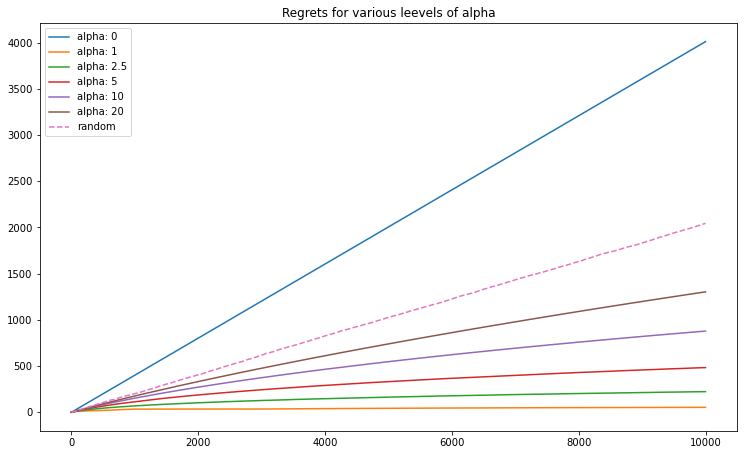

In [12]:
N_EXPERIMENTS = 1
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
experiments = {alpha: [] for alpha in alpha_to_test}

for exp in np.arange(N_EXPERIMENTS):
    print(f'Run Experiment {exp}')
    
    # General Setting
    X = make_design_matrix(N_TRIALS, N_ARMS, N_FEATURES)
    true_theta = make_true_theta(N_TRIALS, N_ARMS, N_FEATURES)
    true_y = generate_true_y(X, true_theta)
    true_optimal_arm = np.argmax(true_y, axis=1)
    true_optimal_reward = np.max(true_y, axis=1)
    
    # Run Experiments
    alpha_to_test = [0, 1, 2.5, 5, 10, 20]
    results_dict = {alpha: linUCB_disjoint(alpha, X, true_theta, true_y) for alpha in alpha_to_test}
    
    # Plot Result
    plt.figure(figsize=(12.5, 7.5))
    plt.title("Regrets for various leevels of alpha")
    [plt.plot(results_dict[alpha]['cum_regrets'], label="alpha: "+ str(alpha)) for alpha in alpha_to_test]
    plt.legend()
    
    # Reference Line: Random selected case
    oracle = np.max(true_y, axis=1)
    payoff_random = np.array([generate_reward(chosen_arm_x=X[trial, np.random.choice(N_ARMS)], chosen_true_theta=true_theta[trial,np.random.choice(N_ARMS)]) for trial in np.arange(X.shape[0])])
    plt.plot(np.cumsum(oracle-payoff_random), label = "random", linestyle='--')
    plt.legend()
    
    plt.show()

    for alpha in alpha_to_test: 
        experiments[alpha].append(results_dict[alpha]['cum_regrets'])

## Multiple Experiments
---

Run Experiment 0
LinUCB disjoint with exploration parameter alpha:  0
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, REGRET: 0.4496
LinUCB disjoint with exploration parameter alpha:  1
    Selected_Arm: 0, True_Arm: 7, oracle: 0.9529, payoff: 0.5033, R

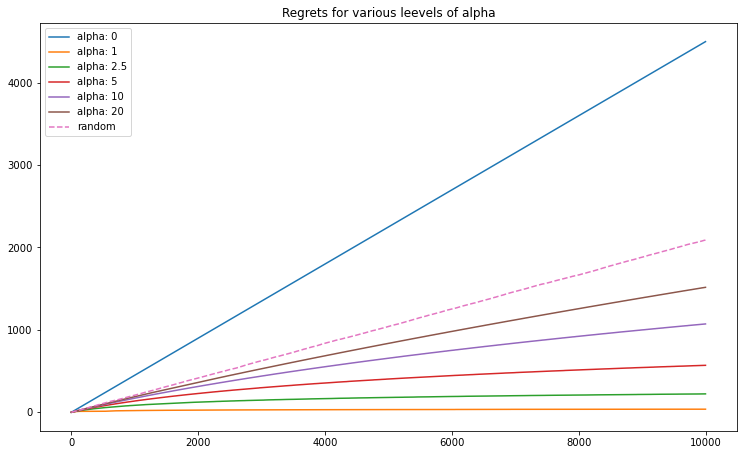

Run Experiment 1
LinUCB disjoint with exploration parameter alpha:  0
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
    Selected_Arm: 0, True_Arm: 2, oracle: 0.9104, payoff: 0.7707, REGRET: 0.1397
LinUCB disjoint with exploration parameter alpha:  1
    Selected_Arm: 4, True_Arm: 2, oracle: 0.9104, payoff: 0.6416, R

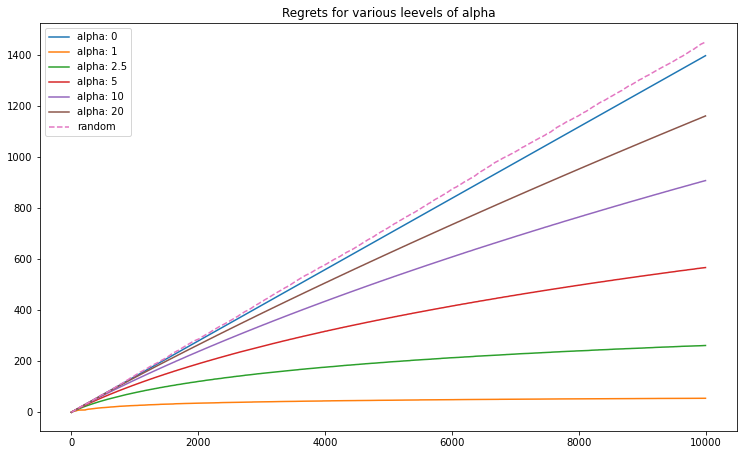

Run Experiment 2
LinUCB disjoint with exploration parameter alpha:  0
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, REGRET: 0.0513
LinUCB disjoint with exploration parameter alpha:  1
    Selected_Arm: 0, True_Arm: 1, oracle: 0.8836, payoff: 0.8323, R

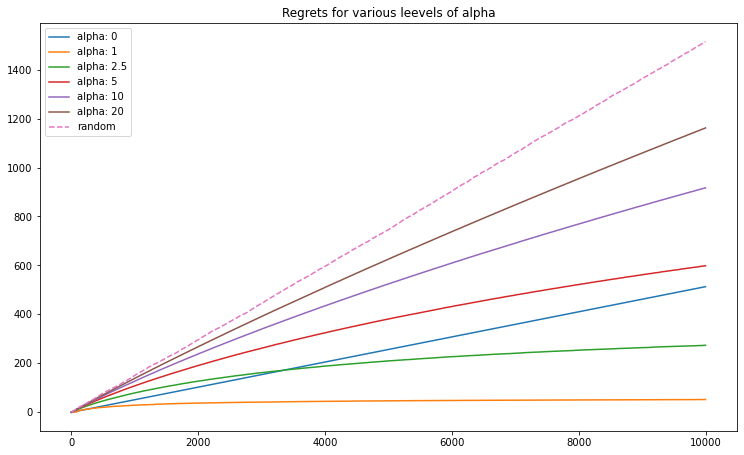

Run Experiment 3
LinUCB disjoint with exploration parameter alpha:  0
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, REGRET: 0.1237
LinUCB disjoint with exploration parameter alpha:  1
    Selected_Arm: 0, True_Arm: 9, oracle: 0.9881, payoff: 0.8644, R

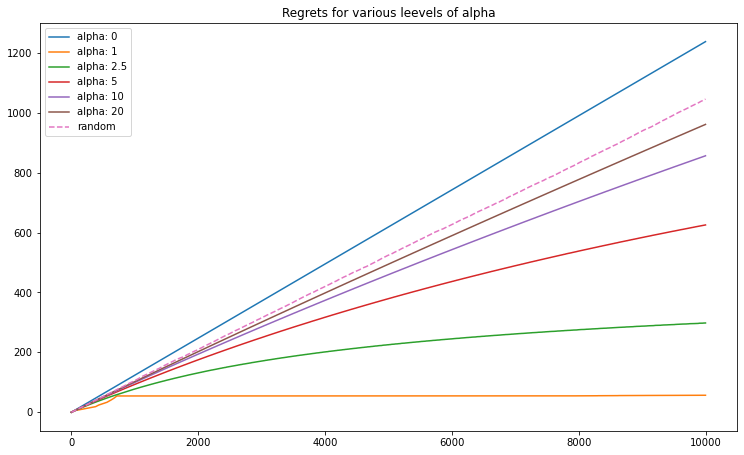

Run Experiment 4
LinUCB disjoint with exploration parameter alpha:  0
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
    Selected_Arm: 0, True_Arm: 1, oracle: 0.9064, payoff: 0.7428, REGRET: 0.1635
LinUCB disjoint with exploration parameter alpha:  1
    Selected_Arm: 4, True_Arm: 1, oracle: 0.9064, payoff: 0.8748, R

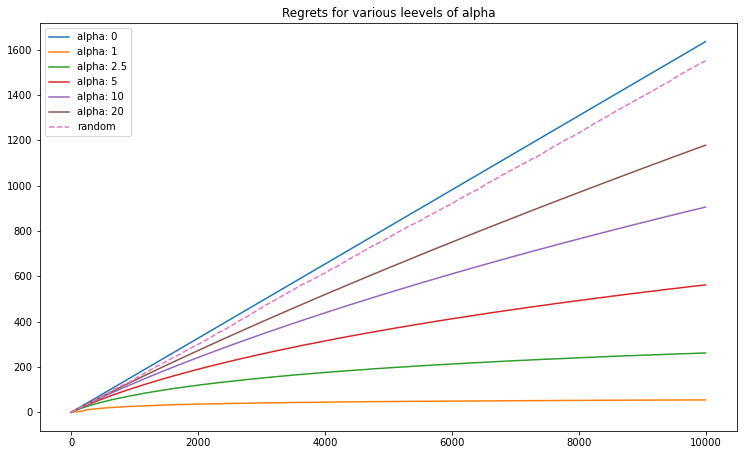

In [13]:
N_EXPERIMENTS = 5
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
experiments = {alpha: [] for alpha in alpha_to_test}

for exp in np.arange(N_EXPERIMENTS):
    print(f'Run Experiment {exp}')
    
    # General Setting
    X = make_design_matrix(N_TRIALS, N_ARMS, N_FEATURES)
    true_theta = make_true_theta(N_TRIALS, N_ARMS, N_FEATURES)
    true_y = generate_true_y(X, true_theta)
    true_optimal_arm = np.argmax(true_y, axis=1)
    true_optimal_reward = np.max(true_y, axis=1)
    
    # Run Experiments
    alpha_to_test = [0, 1, 2.5, 5, 10, 20]
    results_dict = {alpha: linUCB_disjoint(alpha, X, true_theta, true_y) for alpha in alpha_to_test}
    
    # Plot Result
    plt.figure(figsize=(12.5, 7.5))
    plt.title("Regrets for various leevels of alpha")
    [plt.plot(results_dict[alpha]['cum_regrets'], label="alpha: "+ str(alpha)) for alpha in alpha_to_test]
    plt.legend()
    
    # Reference Line: Random selected case
    oracle = np.max(true_y, axis=1)
    payoff_random = np.array([generate_reward(chosen_arm_x=X[trial, np.random.choice(N_ARMS)], chosen_true_theta=true_theta[trial,np.random.choice(N_ARMS)]) for trial in np.arange(X.shape[0])])
    plt.plot(np.cumsum(oracle-payoff_random), label = "random", linestyle='--')
    plt.legend()
    
    plt.show()

    for alpha in alpha_to_test: 
        experiments[alpha].append(results_dict[alpha]['cum_regrets'])

## Average Result 

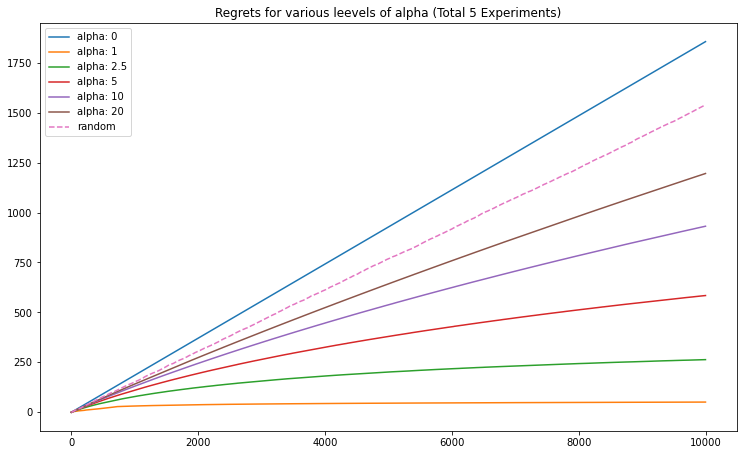

In [14]:
plt.figure(figsize=(12.5, 7.5))
plt.title(f"Regrets for various leevels of alpha (Total {N_EXPERIMENTS} Experiments)")

# Average Results of experiments
for alpha in experiments.keys():
    for exp in np.arange(N_EXPERIMENTS):
        if exp == 0:
            dummy = experiments[alpha][exp]
        else:
            dummy += experiments[alpha][exp]
    dummy /= N_EXPERIMENTS
    plt.plot(dummy, label="alpha: " + str(alpha))
    plt.legend()
    
# Reference Line: Random selected case
oracle = np.max(true_y, axis=1)
payoff_random = np.array([generate_reward(chosen_arm_x=X[trial, np.random.choice(N_ARMS)], chosen_true_theta=true_theta[trial,np.random.choice(N_ARMS)]) for trial in np.arange(X.shape[0])])
plt.plot(np.cumsum(oracle-payoff_random), label = "random", linestyle='--')
plt.legend()

plt.show()
